In [2]:
from qiskit.opflow import I, X, Y, Z # type: ignore
from qiskit_nature.operators.second_quantization import FermionicOp # type: ignore
from qiskit_nature.mappers.second_quantization import JordanWignerMapper # type: ignore
def gamma_corr_op(num_sites, siteA, siteB):
    gamma_corr_1 = FermionicOp("-_"+str(siteA), register_length = num_sites) + FermionicOp("+_"+str(siteA), register_length = num_sites)
    gamma_corr_2 = 1.0j * (FermionicOp("+_"+str(siteB), register_length = num_sites) - FermionicOp("-_"+str(siteB), register_length = num_sites))
    gamma_corr = gamma_corr_1 @ gamma_corr_2

    jw_mapper = JordanWignerMapper
    gamma_corr_JW = [JordanWignerMapper.map(jw_mapper, gamma_corr)]

    return gamma_corr_JW 

gamma_corr_op(5,0,4)
num_sites = 5
siteA = 0
siteB = 0
gamma_corr_1 = FermionicOp("-_"+str(siteA), register_length = num_sites) + FermionicOp("+_"+str(siteA), register_length = num_sites)
gamma_corr_2 = 1.0j * (FermionicOp("+_"+str(siteB), register_length = num_sites) - FermionicOp("-_"+str(siteB), register_length = num_sites))
gamma_corr_1 @ gamma_corr_2


jw_mapper = JordanWignerMapper
gamma_corr_JW = [JordanWignerMapper.map(jw_mapper, gamma_corr_1 @ gamma_corr_2)]
gamma_corr_JW 

[PauliSumOp(SparsePauliOp(['IIIIZ'],
               coeffs=[0.+1.j]), coeff=1.0)]

/tmp/ipykernel_1812/4162489513.py:90: ComplexWarning: Casting complex values to real discards the imaginary part
  levels[i, :] = eigs


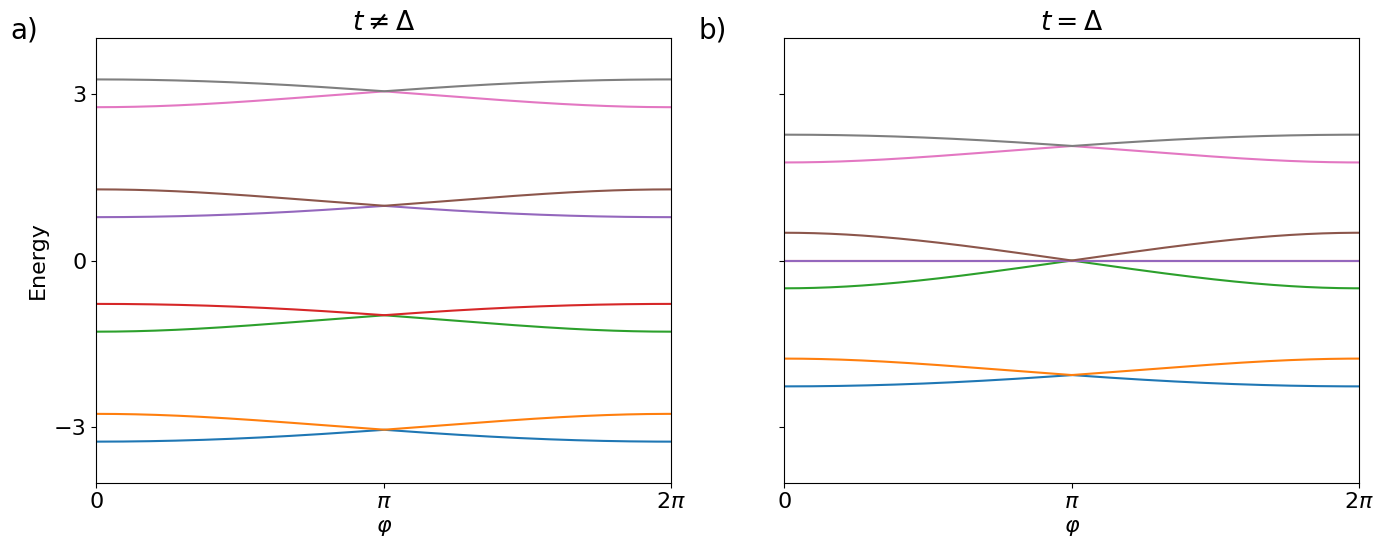

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown

def hamiltonian(eps, t, Delta, t_c):
    """
    Constructs the BdG Hamiltonian matrix.
    
    Args:
        eps (list/np.array): On-site energies [epsilon1, epsilon2, epsilon3, epsilon4].
        t (list/np.array): Tunneling couplings [t_L, t_R].
        Delta (list/np.array): Superconducting pairing potentials [Delta_L, Delta_R].
        t_c (float): Central coupling strength.
        
    Returns:
        np.array: The 8x8 Hamiltonian matrix.
    """
    epsilon1, epsilon2, epsilon3, epsilon4 = eps
    t_L, t_R = t
    Delta_L, Delta_R = Delta

    # Compute complex conjugates
    t_L_star = np.conjugate(t_L)
    t_R_star = np.conjugate(t_R)
    Delta_L_star = np.conjugate(Delta_L)
    Delta_R_star = np.conjugate(Delta_R)

    M = np.array([
        [epsilon1,      t_L,           0,             0,             0,               Delta_L,         0,               0          ],
        [t_L_star,      epsilon2,      t_c,           0,             -Delta_L,        0,               0,               0          ],
        [0,             t_c,           epsilon3,      t_R,           0,               0,               0,               Delta_R    ],
        [0,             0,             t_R_star,      epsilon4,      0,               0,               -Delta_R,        0          ],
        [0,             -Delta_L_star, 0,             0,             -epsilon1,       -t_L_star,       0,               0          ],
        [Delta_L_star,  0,             0,             0,             -t_L,            -epsilon2,       -t_c,            0          ],
        [0,             0,             0,             -Delta_R_star, 0,               -t_c,            -epsilon3,       -t_R_star  ],
        [0,             0,             Delta_R_star,  0,             0,               0,               -t_R,            -epsilon4  ]
    ])
    return M

def compute_eigensystem(eps, t, Delta, t_c):
    """
    Computes and sorts the eigenvalues and eigenvectors of the Hamiltonian.
    """
    H = hamiltonian(eps, t, Delta, t_c)
    eigvals, eigvecs = np.linalg.eig(H)
    idx = np.argsort(eigvals)  # Sort eigenvalues and corresponding vectors
    return eigvals[idx], eigvecs[:, idx]

# --- Main Script ---

# General Parameters
num_sites = 4  # total number of sites/qubits
eps = np.zeros(num_sites)  # ε_i = 0 for all sites
tc = 0.5  # central coupling strength
n = 8  # number of energy levels to plot

# Phase sweep
phi_list = np.linspace(0, 2 * np.pi, 500)

# Define the two cases for the subplots with the new titles
cases = [
    {'t': 1, 'delta': 2, 'label': 'a', 'title': r'$t \neq \Delta$'},
    {'t': 1, 'delta': 1, 'label': 'b', 'title': r'$t = \Delta$'}
]

# --- Plotting Setup ---
plt.rcParams.update({"font.size": 16})
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Loop over the two cases and generate each subplot
for ax, case in zip(axes, cases):
    t_val = case['t']
    delta_val = case['delta']
    label = case['label']
    title = case['title']
    
    levels = np.zeros((len(phi_list), n))

    # Loop over phi values, compute eigenvalues
    for i, phi in enumerate(phi_list):
        # Define parameters based on the current case
        delta0 = delta_val * np.exp(-1j * phi / 2)
        delta1 = delta_val * np.exp(1j * phi / 2)
        t0 = t_val
        t1 = t_val
        
        # Get numeric Hamiltonian and eigenvalues
        eigs, _ = compute_eigensystem(eps, [t0, t1], [delta0, delta1], tc)
        levels[i, :] = eigs

    # Plot the energy levels for the current case
    for j in range(n):
        ax.plot(phi_list, levels[:, j])

    # --- Formatting for each subplot ---
    ax.set_title(title)
    ax.set_xlim([0, 2 * np.pi])
    ax.set_xlabel(r'$\varphi$')
    
    # Add subplot labels a) and b)
    ax.text(-0.15, 1.0, f'{label})', transform=ax.transAxes,
            size=20)

    # X-axis ticks
    ticks = [0, np.pi, 2 * np.pi]
    tick_labels = [r'$0$', r'$\pi$', r'$2\pi$']
    ax.set_xticks(ticks, tick_labels)

# --- Global Figure Formatting ---
y_limit = np.ceil(np.max(np.abs(levels))) + 1 # Dynamic y-limit based on data
axes[0].set_ylim([-y_limit, y_limit])
axes[0].set_ylabel('Energy')

# Adjust y-ticks based on the dynamic limit
if y_limit <= 3:
    axes[0].set_yticks([-2, 0, 2])
else:
    axes[0].set_yticks([-3, 0, 3])


# Adjust layout, save and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.savefig("figures/energy_spectrum_comparison_revised.pdf")
plt.show()